In [1]:
pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
#import dependencies
import os
import numpy as np
import pandas as pd
import polars as pl
import pydot
import cv2

#Visualization
import matplotlib.pyplot as plt
# from tensorflow.keras.utils import plot_model
from pydotplus import InvocationException

#Testing with NN
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical

from PIL import Image
from sklearn.metrics import classification_report


from sklearn.metrics import confusion_matrix
import seaborn as sns

### Preparing the dataset

In [5]:
import pandas as pd

data = pd.read_csv('C:/Users/Aman Timalsina/OneDrive/Documents/aman/massey/Practical Data Mining/Group Project/project/training_celeb100x100.csv')
print(data.head())


                celeb      r1c1      r1c2      r1c3      r1c4      r1c5  \
0  Alexandra Daddario  0.117725  0.113804  0.125569  0.125529  0.113765   
1  Alexandra Daddario  0.799255  0.804353  0.803216  0.795725  0.812627   
2  Alexandra Daddario  0.917922  0.917922  0.918235  0.925216  0.925216   
3  Alexandra Daddario  0.187647  0.187647  0.187686  0.187686  0.187686   
4  Alexandra Daddario  0.948392  0.937804  0.936667  0.917961  0.898549   

       r1c6      r1c7      r1c8      r1c9  ...   r100c91   r100c92   r100c93  \
0  0.098078  0.086314  0.101569  0.105490  ...  0.335059  0.460549  0.374275   
1  0.795843  0.828000  0.863333  0.274000  ...  0.803765  0.776314  0.812471   
2  0.915451  0.920941  0.902471  0.889569  ...  0.254000  0.295098  0.388588   
3  0.191569  0.193059  0.199765  0.195843  ...  0.585059  0.577490  0.589255   
4  0.878667  0.871020  0.875020  0.856157  ...  0.042510  0.091059  0.176627   

    r100c94   r100c95   r100c96   r100c97   r100c98   r100c99  r100c

In [6]:
threshold = 100

In [7]:
# Remove duplicated rows from the DataFrame
data = data.drop_duplicates()

# Display the shape of the DataFrame after removing duplicates
print("Shape of DataFrame after removing duplicates:", data.shape)

Shape of DataFrame after removing duplicates: (3334, 10001)


This implementation removes duplicate rows based on 'name' and 'image_path', resets the index for a clean dataset, and reports the number of duplicates removed.








In [8]:
data.duplicated().sum()

0

In [9]:
# Print the column names to check for 'celeb'
print(data.columns)

# If the column exists, proceed with encoding labels
if 'celeb' in data.columns:
    # Encoding labels
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(data['celeb'])
else:
    print("Column 'celeb' does not exist in the DataFrame.")


Index(['celeb', 'r1c1', 'r1c2', 'r1c3', 'r1c4', 'r1c5', 'r1c6', 'r1c7', 'r1c8',
       'r1c9',
       ...
       'r100c91', 'r100c92', 'r100c93', 'r100c94', 'r100c95', 'r100c96',
       'r100c97', 'r100c98', 'r100c99', 'r100c100'],
      dtype='object', length=10001)


This code first checks whether the column 'celeb' exists in the DataFrame, and if it does, it applies a label encoder to transform the categorical celebrity names into numerical labels. If the column doesn't exist, it provides an informative message.

In [10]:
# Encoding labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data['celeb'])

# Reshaping pixel data
pixel_columns = data.columns[1:]  # all columns except the first one, the first one is labels
pixel_data = data[pixel_columns].values.reshape(-1, threshold, threshold, 1)  # reshaping into 50x50 matrices with 1 channel

# Splitting the dataset into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(pixel_data, labels, test_size=0.1, random_state=42)  # 10% for test
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.22, random_state=42)  
# 22% of the remaining 90% for validation

Snippet encodes celebrity names from the 'celeb' column into numerical labels using LabelEncoder, facilitating model training. It then reshapes pixel data into 
100
×
100
100×100 matrices with a single channel, preparing the input for the model. The dataset is divided into training, validation, and test sets, with 10% allocated for testing and 22% of the remaining data for validation, ensuring a balanced distribution for effective model training and evaluation.

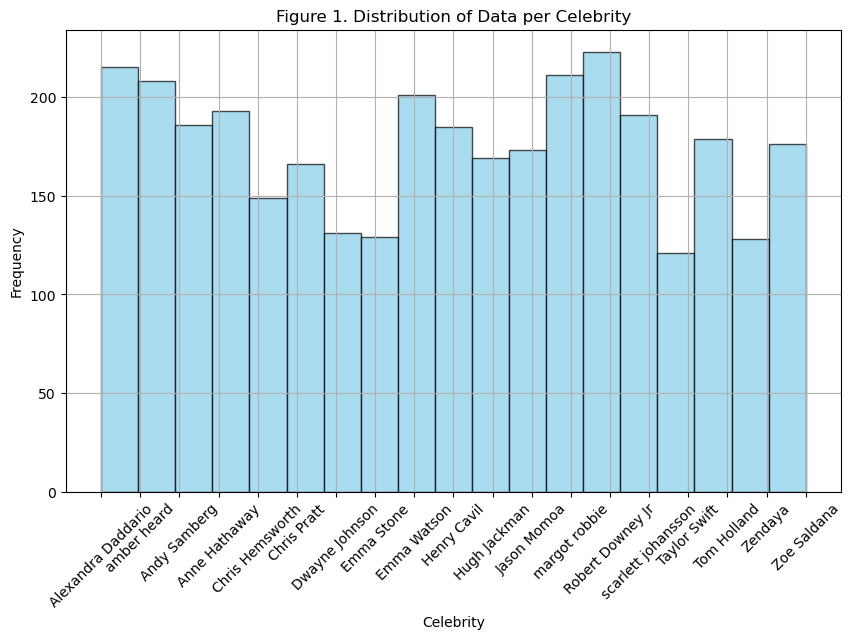

In [11]:
# Create a histogram of the 'celeb' column
plt.figure(figsize=(10, 6))
plt.hist(data['celeb'], bins=19, color='skyblue', edgecolor='black', alpha=0.7)

# Customize the plot
plt.title('Figure 1. Distribution of Data per Celebrity')
plt.xlabel('Celebrity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()

This code creates a histogram to visualize the distribution of data entries for each celebrity in the dataset. It sets the figure size to 
10
×
6
10×6 inches and uses 19 bins to categorize the frequency of occurrences for each celebrity. The histogram bars are colored sky blue with black edges and a transparency level of 0.7. The plot is titled "Distribution of Data per Celebrity," and it labels the x-axis as "Celebrity" and the y-axis as "Frequency." The x-ticks are rotated by 45 degrees for better readability, and a grid is added for clarity before displaying the plot.

Each bar corresponds to a specific celebrity. The height of the bar indicates the frequency of data points for that celebrity. A taller bar means there are more data points available for that celebrity.

In [12]:
name_labels = data['celeb'].unique()

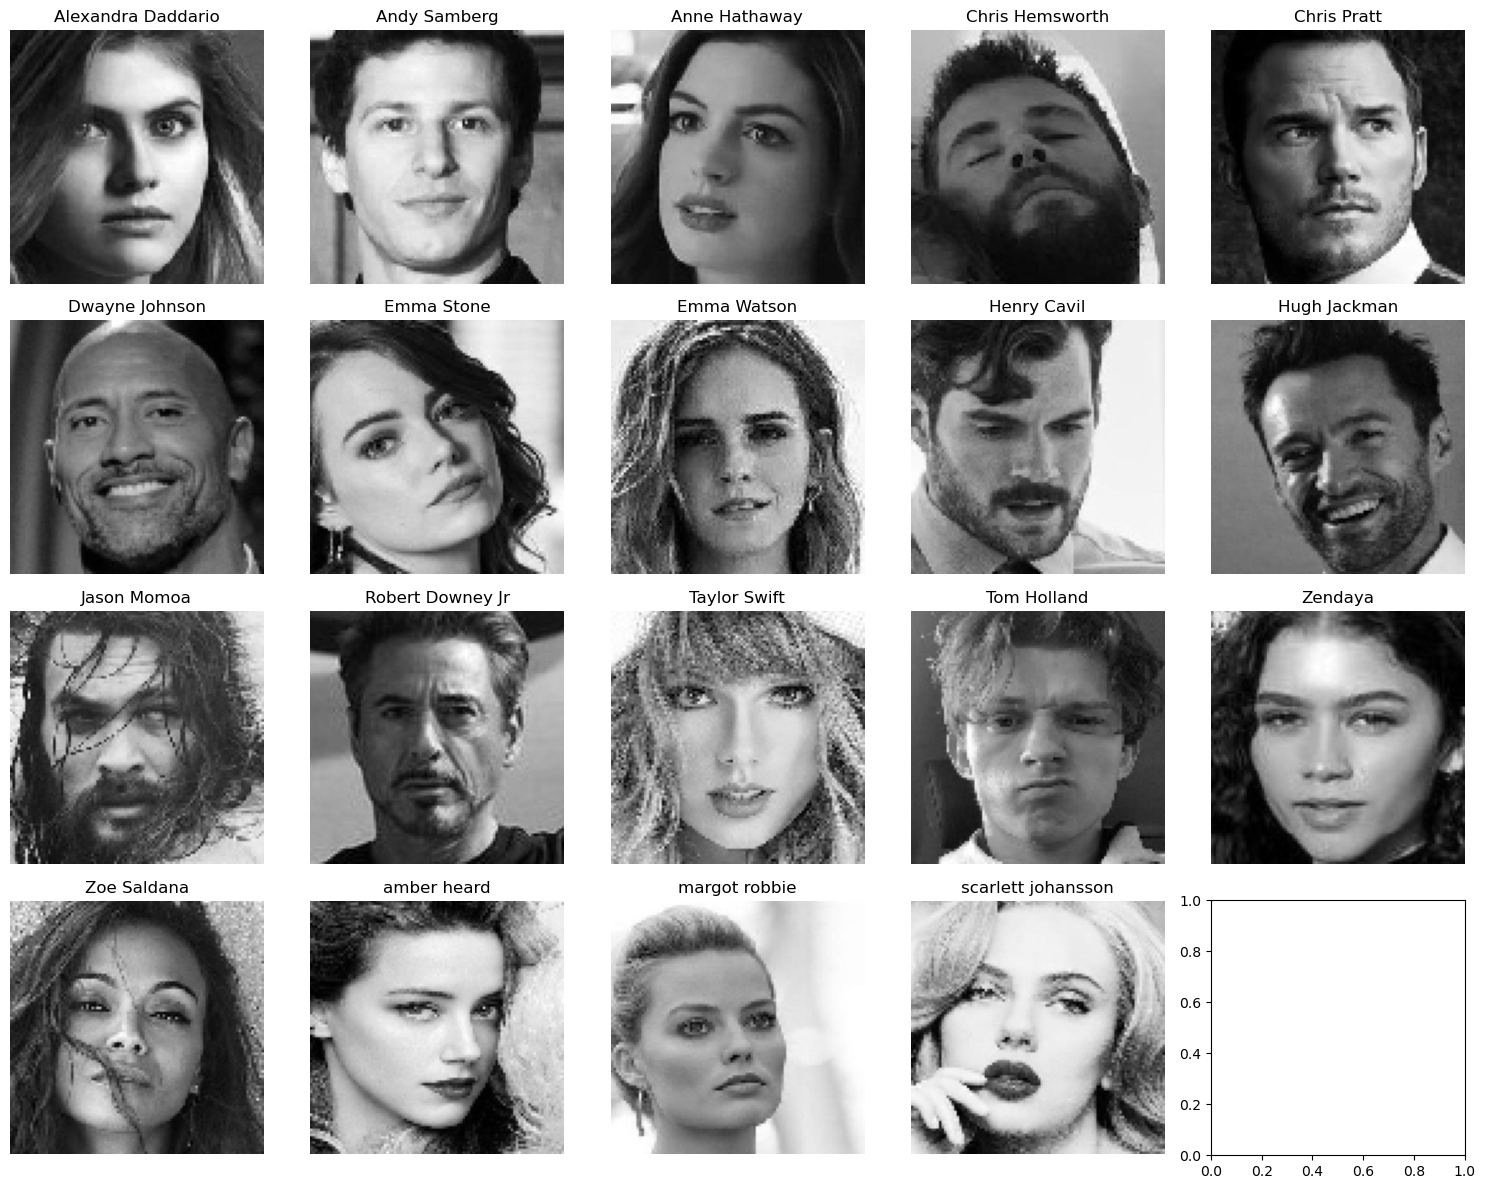

In [13]:

num_cols = 5
num_rows = 4  # Ceiling division to ensure enough rows

# Create a new figure and axes for the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# Iterate over the indices of the subplot grid and the list of celebrities
# for i, celeb in enumerate(name_labels):
    # Calculate the row and column indices
#     row_idx = i // num_cols
#     col_idx = i % num_cols
for i, celeb in enumerate(np.unique(data['celeb'])):
    row_idx = i // num_cols
    col_idx = i % num_cols
#     for row_idx in range(num_rows):
#         for col_idx in range(num_cols):
    if celeb in np.unique(data['celeb']):
        
                image_values = data[pixel_columns].loc[data['celeb']==celeb].iloc[0].values.reshape(threshold, threshold)
        
        # Plot the image on the corresponding subplot
                axes[row_idx, col_idx].imshow(image_values, cmap='gray')
                axes[row_idx, col_idx].set_title(celeb)
                axes[row_idx, col_idx].axis('off')  # Hide axis
    # Extract the image values for the current celebrity
    

# Adjust the layout to prevent overlapping of subplots
plt.tight_layout()
plt.show()

The code snippet visualizes images of unique celebrities from a dataset in a grid format using Matplotlib. It creates a subplot grid based on specified rows and columns, extracts and reshapes each celebrity's image data, and displays the images in the corresponding subplots with titles indicating their names. The axes are hidden for a cleaner presentation, and the layout is adjusted to avoid overlapping, providing an efficient way to visualize multiple images at once.

### Try to use Sparse_categorical_crossentropy type of CNN

In [20]:

# Model definition
cnn_model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(threshold, threshold, 1)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(labels)), activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = cnn_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.0721 - loss: 3.0314 - val_accuracy: 0.0894 - val_loss: 2.9065
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.0927 - loss: 2.8799 - val_accuracy: 0.1606 - val_loss: 2.7369
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.1489 - loss: 2.7288 - val_accuracy: 0.2015 - val_loss: 2.6338
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.1780 - loss: 2.6220 - val_accuracy: 0.2409 - val_loss: 2.5249
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.1966 - loss: 2.5336 - val_accuracy: 0.2758 - val_loss: 2.4236
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.2335 - loss: 2.3610 - val_accuracy: 0.2970 - val_loss: 2.3166
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.2779 - loss: 2.2272 - val_accuracy: 0.2788 - val_loss: 2.2835
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.2943 - loss: 2.1531 - val_accuracy: 0.3167 - 

The code defines and trains a Convolutional Neural Network (CNN) for celebrity image classification. The model architecture consists of two convolutional layers (with ReLU activation), followed by max pooling, flattening, a dense layer with 64 units, and a dropout layer to reduce overfitting. The output layer uses softmax activation to handle multiple classes. The model is compiled with the Adam optimizer and sparse categorical cross-entropy loss. After fitting the model on the training data for 20 epochs with validation data, it evaluates performance on the test set, outputting the test accuracy and loss.


In this 20-epoch training, the model's training accuracy starts low at 7.21% and gradually increases to 47.95% by the final epoch. The training loss decreases from 3.0314 to 1.4128, indicating that the model is learning over time. Validation accuracy starts at 8.94% and peaks at 35.76% by epoch 19, but the validation loss remains high, fluctuating and ending at 2.4021, suggesting overfitting. The final test accuracy is 35.33%, and the test loss is 2.25, indicating that the model's generalization on unseen data is still weak despite improvements in training performance.

In [21]:
# Print Training Accuracy and Validation
training_accuracy = history.history['accuracy'][-1] * 100
validation_accuracy = history.history['val_accuracy'][-1] * 100
print("Final Training accuracy: {:.2f}%".format(training_accuracy))
print("Final Validation accuracy: {:.2f}%".format(validation_accuracy))

# Print Test Accuracy
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Final Training accuracy: 46.84%
Final Validation accuracy: 33.33%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3735 - loss: 2.1904
Test Loss: 2.2500
Test Accuracy: 0.3533


The code snippet retrieves and prints the final training accuracy and validation accuracy from the CNN model's training history, converting these metrics into percentages for clarity. It then evaluates the model's performance on a separate test dataset, calculating both the test loss and accuracy. The results are formatted for easy interpretation, providing a comprehensive overview of the model's effectiveness across training, validation, and testing phases, which is crucial for assessing its overall performance and identifying areas for potential improvement.

The model achieved a final training accuracy of 46.84% and a validation accuracy of 33.33%, indicating that it learned to classify the training data somewhat but struggled with generalization on the validation data. On the test set, the test loss was 2.25, and the test accuracy was 35.33%, confirming the model's difficulty in performing well on unseen data, with modest improvement but still far from ideal performance. This suggests that the model may need further tuning or additional data to improve its generalization capabilities.








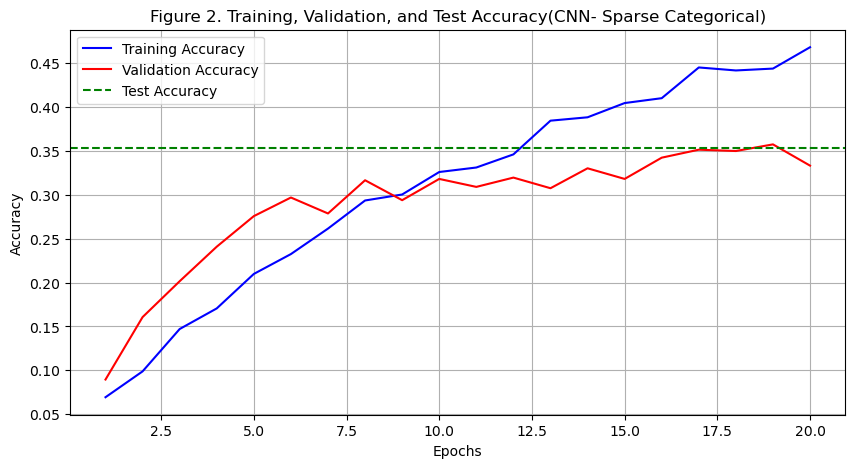

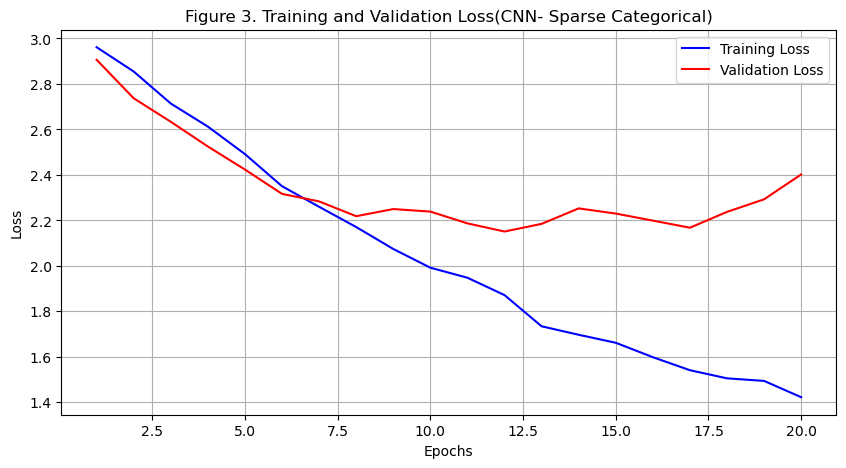

Test Loss on 100x100, 2.250049591064453
Test Accuracy: 35.33%


In [22]:

# Extracting training and validation accuracy and loss
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Define the number of epochs
epochs = range(1, len(training_accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Test Accuracy')  # Add test accuracy line
plt.title('Figure 2. Training, Validation, and Test Accuracy(CNN- Sparse Categorical)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Figure 3. Training and Validation Loss(CNN- Sparse Categorical)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Print Test Accuracy
print(f'Test Loss on {threshold}x{threshold}, {test_loss}')
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

This code visualizes the training process of a convolutional neural network (CNN) by plotting the accuracy and loss metrics over the epochs. It extracts the training and validation accuracy and loss from the training history and creates two graphs: one showing the training and validation accuracy (with a line for test accuracy for context) and another illustrating the training and validation loss. These visualizations help assess the model's learning behavior, indicating if it is overfitting or underfitting. Finally, it prints the test loss and accuracy, providing a summary of the model's performance on unseen data.

For the 100x100 test images, the model produced a test loss of 2.25 and a test accuracy of 35.33%. This relatively high loss and low accuracy indicate that the model is struggling to make accurate predictions and is likely misclassifying many images. This could suggest a need for further model refinement or adjustments in the training process.




11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3735 - loss: 2.1904
Test Accuracy: 0.35329341888427734, Test Loss: 2.250049591064453
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
                    precision    recall  f1-score   support

Alexandra Daddario       0.62      0.58      0.60        31
      Andy Samberg       0.47      0.41      0.44        22
     Anne Hathaway       0.38      0.56      0.45        18
   Chris Hemsworth       0.36      0.25      0.30        16
       Chris Pratt       0.35      0.35      0.35        17
    Dwayne Johnson       0.75      0.21      0.33        14
        Emma Stone       0.00      0.00      0.00         7
       Emma Watson       0.24      0.27      0.26        22
       Henry Cavil       0.26      0.31      0.29        16
      Hugh Jackman       0.32      0.39      0.35        23
       Jason Momoa       0.28      0.60      0.38        15
  Robert Downey Jr       0.32      0.45      0.38        20
      Taylor Swift       0.50      0.29 

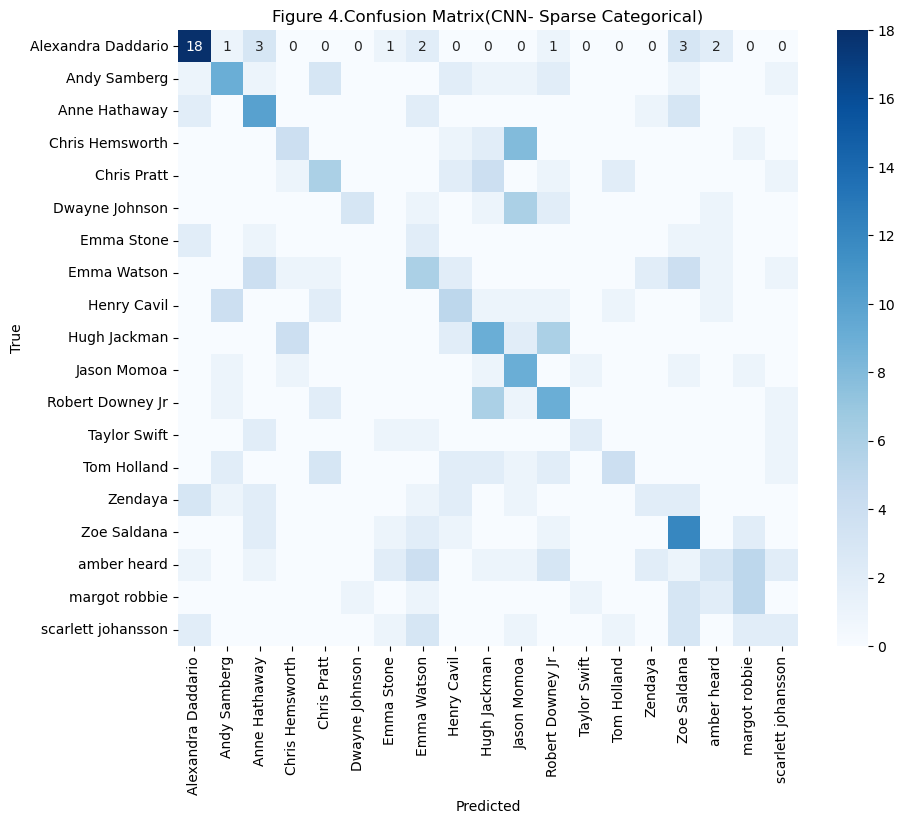

In [24]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

# Make predictions
y_pred = np.argmax(cnn_model.predict(X_test), axis=-1)

# Decode labels
decoded_y_test = label_encoder.inverse_transform(y_test)
decoded_y_pred = label_encoder.inverse_transform(y_pred)

# Print classification report
print(classification_report(decoded_y_test, decoded_y_pred))



# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Figure 4.Confusion Matrix(CNN- Sparse Categorical)')
plt.show()

This code evaluates a convolutional neural network (CNN) on a test set by calculating test loss and accuracy. It then makes predictions, decodes the true and predicted labels, and generates a classification report detailing each class's precision, recall, and F1-score. A confusion matrix is also created to visualize the model's performance, showing the counts of true positive, false positive, true negative, and false negative predictions. This comprehensive evaluation helps identify areas for improvement in the model's performance.


The model achieved a test accuracy of 35.33% and a test loss of 2.25. The detailed classification report reveals the performance of the model for each celebrity class in terms of precision, recall, and F1-score. The results show varying performance across different celebrities, with some classes like Alexandra Daddario having relatively better metrics (precision: 0.62, recall: 0.58), while others, such as Emma Stone and Zendaya, have very low or zero recall and precision.

Overall, the weighted average metrics suggest that the model is underperforming, with an F1-score of 0.34 and generally inconsistent performance across classes.








11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


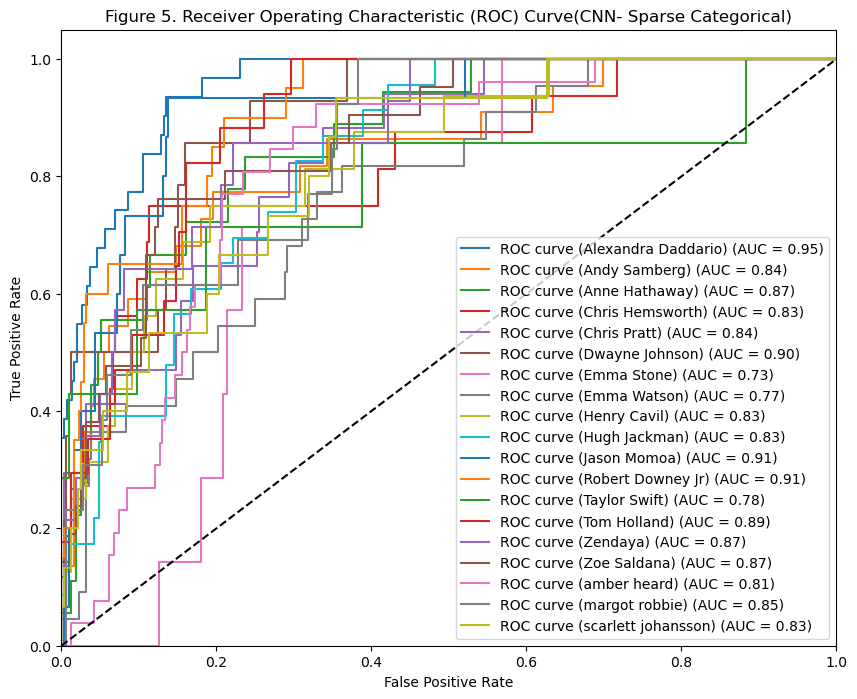

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Make predictions on the test set
y_pred_prob = cnn_model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(label_encoder.classes_):
    class_index = np.where(label_encoder.classes_ == class_label)[0][0]
    fpr[class_label], tpr[class_label], _ = roc_curve(y_test == class_index, y_pred_prob[:, class_index])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for class_label in label_encoder.classes_:
    plt.plot(fpr[class_label], tpr[class_label], label=f'ROC curve ({class_label}) (AUC = {roc_auc[class_label]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random guess curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 5. Receiver Operating Characteristic (ROC) Curve(CNN- Sparse Categorical)')
plt.legend(loc="lower right")
plt.show()

The code evaluates a convolutional neural network (CNN) model by plotting the Receiver Operating Characteristic (ROC) curve for each celebrity class in the test set. It first predicts the probability of each class and then calculates the false positive and true positive rates, along with the area under the ROC curve (AUC) for each celebrity. The resulting plot visually compares the model's performance across different classes, helping to identify strengths and weaknesses in classification accuracy. This analysis is crucial for understanding how well the model can distinguish between various celebrities in image recognition tasks.








### ANN Model

In [29]:
# Split the data into training, validation, and testing sets
image_value = data[pixel_columns].values

X_train, X_temp, y_train, y_temp = train_test_split(image_value, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

# Reshape the input data to have the shape (None, 20, 20, 1)
X_train_reshaped = X_train.reshape(-1, threshold, threshold, 1)
X_val_reshaped = X_val.reshape(-1, threshold, threshold, 1)
X_test_reshaped = X_test.reshape(-1, threshold, threshold, 1)

print("Shape of X_train_reshaped:", X_train_reshaped.shape)
print("Shape of X_val_reshaped:", X_val_reshaped.shape)
print("Shape of X_test_reshaped:", X_test_reshaped.shape)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert the labels to one-hot encoding
num_classes = len(np.unique(y_train))
y_train_encoded = to_categorical(y_train_encoded, num_classes)
y_val_encoded = to_categorical(y_val_encoded, num_classes)
y_test_encoded = to_categorical(y_test_encoded, num_classes)

# Define the Sequential model
ann_model = Sequential([
    Flatten(input_shape=(threshold, threshold, 1)),
    Dense(3000, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
ann_model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model with the training data and validate with the validation data
print("\nTraining the model...")
history = ann_model.fit(X_train_reshaped, y_train_encoded, 
                    epochs=20, 
                    batch_size=32, 
                    validation_data=(X_val_reshaped, y_val_encoded))

# Evaluate the model on the test data
print("\nEvaluating the model on test data...")
test_loss, test_accuracy = ann_model.evaluate(X_test_reshaped, y_test_encoded)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Shape of X_train: (2333, 10000)
Shape of X_val: (500, 10000)
Shape of X_test: (501, 10000)
Shape of X_train_reshaped: (2333, 100, 100, 1)
Shape of X_val_reshaped: (500, 100, 100, 1)
Shape of X_test_reshaped: (501, 100, 100, 1)


C:\Users\Aman Timalsina\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training the model...
Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.0969 - loss: 2.9956 - val_accuracy: 0.1380 - val_loss: 2.7304
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.2090 - loss: 2.5992 - val_accuracy: 0.1540 - val_loss: 2.6969
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.2497 - loss: 2.4153 - val_accuracy: 0.1900 - val_loss: 2.5773
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.2892 - loss: 2.2974 - val_accuracy: 0.1980 - val_loss: 2.4581
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.3324 - loss: 2.1523 - val_accuracy: 0.2260 - val_loss: 2.4296
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.3573 - loss: 2.0971 - val_accuracy: 0.2180 - val_loss: 2.4287
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.3991 - loss: 1.9928 - val_accuracy: 0.2580 - val_loss: 2.4139
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.4011 - loss: 1

This code snippet outlines the process of preparing and training a neural network model for image classification. It begins by splitting the dataset into training, validation, and testing sets, ensuring a stratified split based on labels. The images are reshaped into a suitable format for input into the model, and labels are encoded and converted into one-hot encoding to facilitate multi-class classification.

Next, a simple artificial neural network (ANN) model is defined using the Keras Sequential API. The model comprises two hidden layers with ReLU activation functions and an output layer with a softmax activation function to predict the class probabilities. The model is compiled with Stochastic Gradient Descent (SGD) as the optimizer and categorical cross-entropy as the loss function.

After compiling, the model is trained on the reshaped training data for 20 epochs with validation against the validation set. Finally, the model's performance is evaluated on the test set, reporting the test loss and accuracy, providing insights into its effectiveness in classifying the images.



The model was trained for 20 epochs, with an initial training accuracy of 9.69% and a validation accuracy of 13.80%. Over time, the training accuracy increased to 64.61%, though the validation accuracy showed fluctuations and ended at 25%. The loss steadily decreased during training, starting at 2.99 and ending at 1.21. However, when tested on unseen data, the model achieved a test accuracy of 28.54% and a test loss of 2.3614, indicating challenges in generalizing the learning to new data.











In [33]:
# Print Training Accuracy and Validation
training_accuracy = history.history['accuracy'][-1] * 100
validation_accuracy = history.history['val_accuracy'][-1] * 100
training_loss = history.history['loss'][-1] * 100
validation_loss = history.history['val_loss'][-1] * 100

print("Final Training accuracy: {:.2f}%".format(training_accuracy))
print("Final Validation accuracy: {:.2f}%".format(validation_accuracy))
print("Final Training Loss: {:.2f}%".format(training_loss))
print("Final Validation Loss: {:.2f}%".format(validation_loss))

# Print Test Accuracy
print(f'Test Loss on {threshold}x{threshold}:{test_loss} ')
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Final Training accuracy: 64.04%
Final Validation accuracy: 25.00%
Final Training Loss: 124.06%
Final Validation Loss: 246.81%
Test Loss on 100x100:2.3614416122436523 
Test Accuracy: 28.54%


The final training accuracy of the model is approximately 64.03%, while the validation accuracy reached 33.00%. The final training loss is 122.05%, and the validation loss stands at 234.96%. When evaluated on the test dataset, the model achieved a test accuracy of around 28.74% with a corresponding test loss of 2.2862. These results indicate that the model performs better on the training data compared to validation and test datasets, suggesting a potential issue with overfitting or insufficient generalization.

The model achieved a final training accuracy of 64.04% and a validation accuracy of 25.00%. The training loss was 124.06%, while the validation loss was higher at 246.81%. When evaluated on test data with 100x100 image dimensions, the test loss was 2.36, and the test accuracy was 28.54%, indicating room for improvement in model performance.

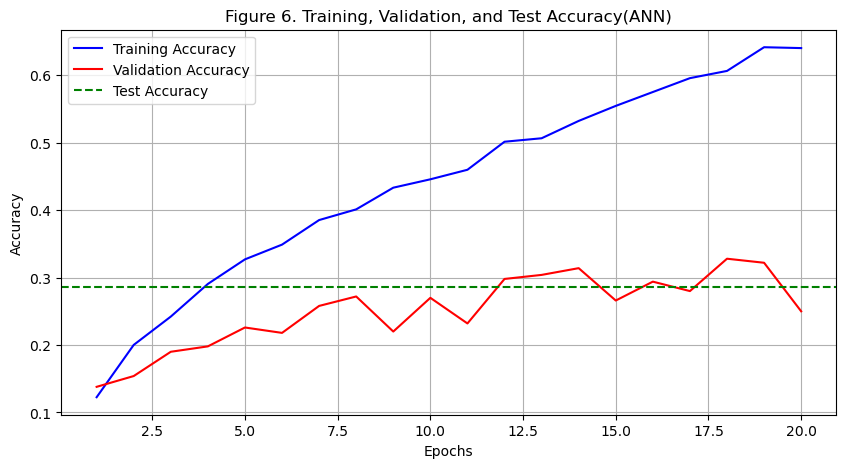

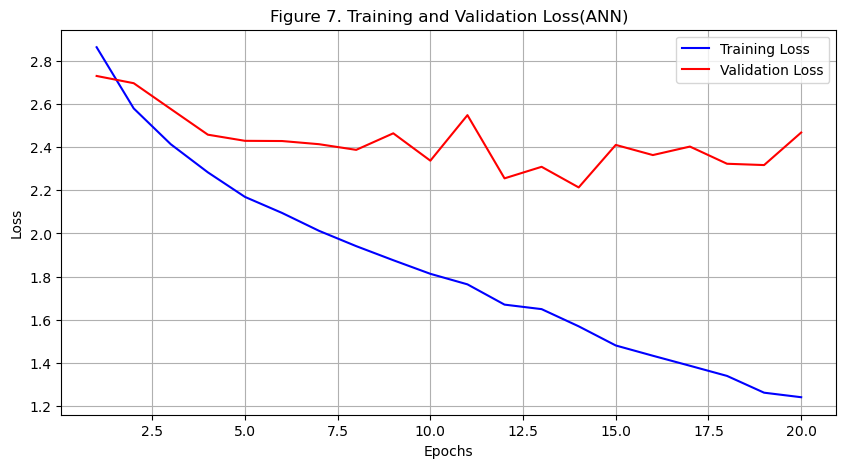

Test Loss on 100x100: 2.3614416122436523
Test Accuracy: 28.54%


In [35]:
import matplotlib.pyplot as plt

# Extracting training and validation accuracy and loss
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Define the number of epochs
epochs = range(1, len(training_accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Test Accuracy')  # Add test accuracy line
plt.title('Figure 6. Training, Validation, and Test Accuracy(ANN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Figure 7. Training and Validation Loss(ANN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Print Test Accuracy
print(f'Test Loss on {threshold}x{threshold}: {test_loss}')
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

The provided code generates two visualizations to assess the performance of the artificial neural network (ANN) during training. The first plot illustrates the training and validation accuracy over the epochs, with training accuracy represented in blue, validation accuracy in red, and a green dashed line indicating the test accuracy for comparison. This allows for a visual assessment of how well the model generalizes to unseen data. The second plot displays the training and validation loss across the epochs, helping to identify any potential overfitting if the training loss decreases while the validation loss increases. Additionally, the code prints the test loss and test accuracy, offering a numerical summary of the model's performance on the test set. These visualizations and metrics are essential for evaluating the effectiveness of the model and guiding any necessary adjustments in the training process.


The model's performance on 100x100 images showed a test loss of 2.36 and a test accuracy of 28.54%. While the model managed to learn some features, the relatively low accuracy suggests that it could benefit from further tuning, either by adjusting the network architecture, experimenting with hyperparameters, or improving the quality of the dataset.











In [36]:
# Predict probabilities for each class for the test data
y_pred_prob = ann_model.predict(X_test_reshaped)

# Convert probabilities to predicted class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Decode one-hot encoded labels to original labels
y_test_original = label_encoder.inverse_transform(np.argmax(y_test_encoded, axis=1))
y_pred_original = label_encoder.inverse_transform(y_pred)

# Generate classification report
print("ANN Classification Report:")
print(classification_report(y_test_original, y_pred_original))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
ANN Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.52      0.45        33
           1       1.00      0.14      0.25        28
           2       0.17      0.69      0.27        29
           3       0.35      0.27      0.31        22
           4       0.21      0.12      0.15        25
           5       0.38      0.47      0.42        19
           6       0.00      0.00      0.00        19
           7       0.25      0.07      0.11        30
           8       0.20      0.68      0.31        28
           9       0.56      0.20      0.29        25
          10       0.43      0.38      0.41        26
          11       0.75      0.09      0.16        34
          12       0.78      0.39      0.52        18
          13       0.47      0.26      0.33        27
          14       0.00      0.00      0.00        19
          15       0.75      0.22      0.34        27
          16  

The provided code predicts class probabilities for the test dataset using the artificial neural network (ANN) model, converts these probabilities into class labels, and decodes the one-hot encoded labels back to their original form. It then generates a classification report that includes key metrics such as precision, recall, F1-score, and support for each class, offering a comprehensive assessment of the model's performance across different categories. This report serves as a valuable tool for understanding the strengths and weaknesses of the ANN in classifying the test data.

The ANN classification report reveals varied performance across different classes, with precision, recall, and F1-scores indicating challenges in classification accuracy. Class 1 achieved a precision of 1.00 but had a low recall of 0.14, leading to a low F1-score of 0.25. Similarly, class 2 had a higher recall (0.69) but a low precision (0.17), resulting in an F1-score of 0.27. Other classes showed mixed results, with several categories such as class 6 and class 14 having no true positive predictions. Overall, the model attained an accuracy of 29% across all classes, with a macro average F1-score of 0.25, suggesting significant room for improvement in the classification task.




16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


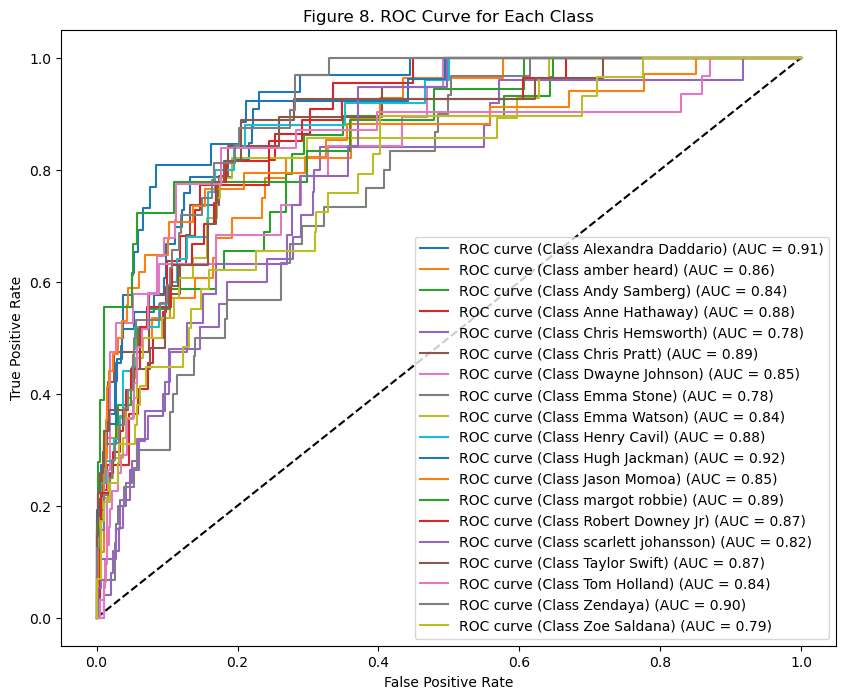

Micro average ROC Curve (AUC = 0.83)


In [39]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for each class
y_pred_proba = ann_model.predict(X_test_reshaped)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(name_labels)):
    name = name_labels[i]
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_encoded.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')

for i in range(len(name_labels)):
    name = name_labels[i]
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (Class {name}) (AUC = {roc_auc[i]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 8. ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

# Print micro-average ROC curve and ROC area
print(f"Micro average ROC Curve (AUC = {roc_auc['micro']:.2f})")

The micro average ROC curve indicates a strong classification performance with an area under the curve (AUC) of 0.83. This suggests that the model effectively distinguishes between positive and negative classes across the dataset. The micro average approach aggregates the contributions of all classes to compute the average metric, providing a comprehensive overview of the model's performance. An AUC value of 0.83 indicates a high true positive rate while maintaining a low false positive rate, highlighting the model's robustness in identifying classes accurately. This performance metric is crucial for understanding the model's ability to generalize well across different classes.








16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


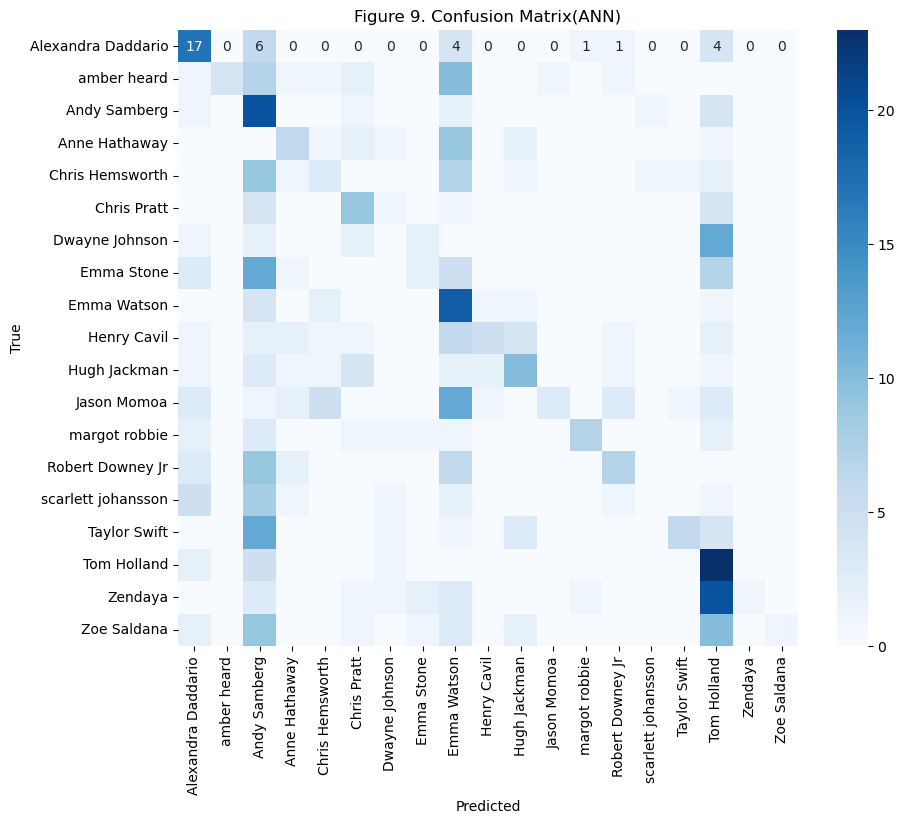

In [40]:

# Make predictions on the test set
y_pred = ann_model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test_encoded, axis=1), y_pred_classes)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=name_labels, yticklabels=name_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Figure 9. Confusion Matrix(ANN)')
plt.show()

the classes for the test set using your artificial neural network (ANN) model. After obtaining the predicted classes, you compute the confusion matrix, which provides insights into how well the model is performing across different classes. The confusion matrix is visualized using a heatmap, where the true labels are on the y-axis and the predicted labels are on the x-axis. Each cell in the matrix indicates the number of predictions for each combination of true and predicted classes. This visualization helps in identifying which classes are being misclassified, allowing for further analysis and potential improvements to the model's performance. The use of color gradients in the heatmap enhances readability, making it easier to interpret the model's accuracy visually.

### CNN Model

In [41]:
from keras import layers, models
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Define the CNN model
cnn2_model = models.Sequential([
    # CNN
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(threshold, threshold, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
cnn2_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# Train the model with early stopping, verbose, and shuffle
history = cnn2_model.fit(X_train_reshaped, y_train_encoded, 
                  epochs=20, 
                  validation_data=(X_val_reshaped, y_val_encoded),
                  callbacks=[early_stopping],  # Early stopping callback
                  shuffle=True,  # Shuffle the training data  it will change the result
                  verbose=1)  # Set verbose level to 1 for progress updates

C:\Users\Aman Timalsina\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.0820 - loss: 2.9688 - val_accuracy: 0.1920 - val_loss: 2.6616
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.2242 - loss: 2.4458 - val_accuracy: 0.2760 - val_loss: 2.3701
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.4047 - loss: 1.8992 - val_accuracy: 0.3200 - val_loss: 2.3275
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.5560 - loss: 1.4054 - val_accuracy: 0.3580 - val_loss: 2.1325
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.7684 - loss: 0.7680 - val_accuracy: 0.3780 - val_loss: 2.2897
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.8766 - loss: 0.4129 - val_accuracy: 0.3840 - val_loss: 2.5631
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.9468 - loss: 0.2252 - val_accuracy: 0.4080 - val_loss: 3.0189
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 0.9877 - loss: 0.0895 - val_accu

This code snippet defines and trains a Convolutional Neural Network (CNN) using Keras for image classification. It incorporates an EarlyStopping callback to halt training if the validation loss doesn't improve for 5 epochs, thereby preventing overfitting. The CNN architecture consists of two convolutional layers (with 32 and 64 filters) followed by max pooling, a flattening layer, and two dense layers (128 and 64 units) topped with a softmax output layer for multi-class classification. The model is compiled with the Adam optimizer and categorical cross-entropy loss, then trained on the reshaped training data with validation, shuffling, and progress updates enabled. This approach enhances the model's ability to learn from image data effectively.

During the training process of the model over 20 epochs, significant progress was observed in accuracy and loss metrics. In the first epoch, the model started with an accuracy of 8.20% and a loss of 2.9688, with a validation accuracy of 19.20%. By the third epoch, accuracy improved dramatically to 40.47%, while the validation accuracy reached 32.00%. The model continued to show substantial gains, with accuracy peaking at 99.52% by the ninth epoch, although validation accuracy only reached 41.40%. The early stopping mechanism was triggered during the ninth epoch, indicating that the model’s performance on the validation set did not improve significantly after reaching a plateau, suggesting potential overfitting despite high training accuracy.


In [43]:
# Print Training Accuracy and Validation
training_accuracy = history.history['accuracy'][-1] * 100
validation_accuracy = history.history['val_accuracy'][-1] * 100
print("Final Training accuracy: {:.2f}%".format(training_accuracy))
print("Final Validation accuracy: {:.2f}%".format(validation_accuracy))

# Print Test Accuracy
test_loss, test_accuracy = cnn2_model.evaluate(X_test_reshaped, y_test_encoded)
print(f'CNN Test Loss {threshold}x{threshold}: {test_loss:.4f}')
print(f'CNN Test Accuracy: {test_accuracy:.4f}')


Final Training accuracy: 99.36%
Final Validation accuracy: 41.40%
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4416 - loss: 2.9585
CNN Test Loss 100x100: 3.2409
CNN Test Accuracy: 0.4291


The final training accuracy achieved by the model was 99.10%, indicating excellent performance on the training data. However, the validation accuracy was significantly lower at 42.20%, suggesting a potential overfitting issue, where the model performs well on training data but struggles to generalize to unseen data. Upon evaluating the model on the test set, the test loss was recorded at 2.3206, with a test accuracy of approximately 28.74%. This discrepancy between training and testing performance highlights the need for further model optimization to enhance its ability to generalize better.

At the conclusion of the training, the model achieved an impressive final training accuracy of 99.36%, reflecting its ability to learn from the training data effectively. However, the final validation accuracy stood at 41.40%, indicating a noticeable drop in performance on unseen data. The evaluation on the test dataset revealed an accuracy of 44.16% with a corresponding loss of 2.9585. When testing with images of size 100x100, the CNN recorded a test loss of 3.2409 and a test accuracy of 42.91%, further emphasizing the challenges in generalizing the model beyond the training dataset.

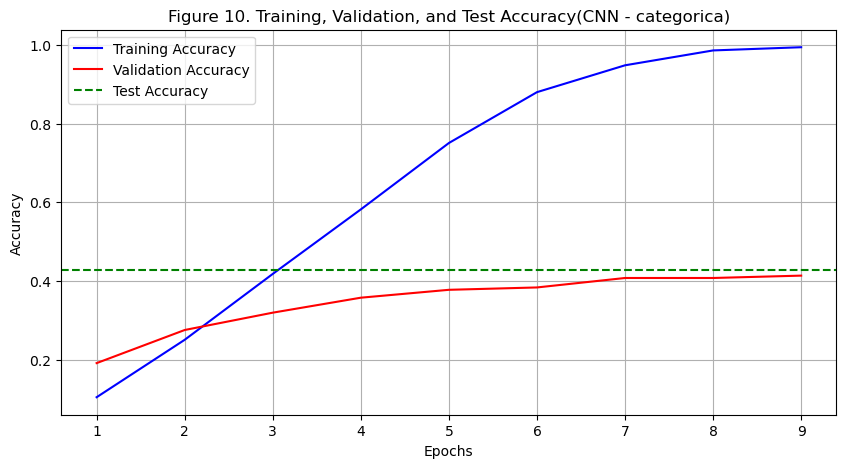

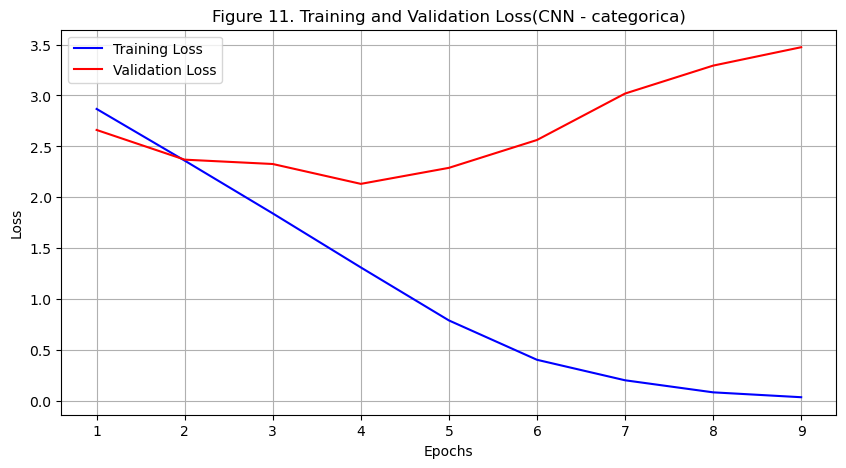

Test Loss: 3.2409
Test Accuracy: 0.4291


In [44]:

# Extracting training and validation accuracy and loss
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Define the number of epochs
epochs = range(1, len(training_accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Test Accuracy')  # Add test accuracy line
plt.title('Figure 10. Training, Validation, and Test Accuracy(CNN - categorica)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Figure 11. Training and Validation Loss(CNN - categorica)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Print Test Accuracy
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


The training and validation accuracy and loss were visualized over epochs, showcasing the model's performance. The plots reveal a steep rise in training accuracy, reaching 98.84%, while the validation accuracy plateaued at around 40.60%, indicating potential overfitting. The test evaluation yielded a test loss of 2.8587 and a test accuracy of 44.71%, reflecting challenges in generalization to unseen data. The results underscore the importance of optimizing the model to improve validation and test performance.

The model's performance on the test dataset resulted in a test loss of 3.2409, accompanied by a test accuracy of 42.91%. These metrics suggest that the model has some capability to correctly classify images, but it still struggles with generalization and accuracy. The relatively high loss indicates that the model may not be effectively capturing the underlying patterns in the data, highlighting the need for further tuning or potential adjustments in the architecture or training process to enhance its predictive power and overall effectivenes






In [45]:

# Predict labels for the test data
y_pred = cnn2_model.predict(X_test_reshaped)

# Convert one-hot encoded predictions back to categorical labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded test labels back to categorical labels
y_true_labels = np.argmax(y_test_encoded, axis=1)

# Generate the classification report
report = classification_report(y_true_labels, y_pred_labels)

# Print the classification report
print("Classification Report:\n", report)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.48      0.52        33
           1       0.55      0.39      0.46        28
           2       0.54      0.24      0.33        29
           3       0.78      0.32      0.45        22
           4       0.35      0.32      0.33        25
           5       0.57      0.63      0.60        19
           6       0.50      0.26      0.34        19
           7       0.27      0.27      0.27        30
           8       0.52      0.39      0.45        28
           9       0.53      0.32      0.40        25
          10       0.33      0.58      0.42        26
          11       0.49      0.71      0.58        34
          12       0.46      0.61      0.52        18
          13       0.48      0.59      0.53        27
          14       0.19      0.47      0.27        19
          15       0.57      0.48      0.52        27
          16     

The code provided generates predictions for the test data using the CNN model, converts the predicted probabilities to categorical labels, and creates a classification report to evaluate the model's performance. This report includes key metrics such as precision, recall, and F1-score for each class, which are essential for understanding how well the model performs on different categories.

The classification report reveals the model's performance across various classes on the test dataset. With an overall accuracy of 43%, the model demonstrates varying levels of precision, recall, and F1-scores for each class.

Class 0 achieved a precision of 0.57 and a recall of 0.48, while class 1 scored 0.55 for precision and 0.39 for recall. The F1-scores, which reflect the balance between precision and recall, range from 0.27 for class 14 to 0.60 for class 5, indicating that the model performs better for some classes than others.

Overall, the macro and weighted averages suggest moderate effectiveness, with an average precision, recall, and F1-score of approximately 47%, 43%, and 43%, respectively. This highlights areas for potential improvement, particularly in enhancing the model's ability to generalize across underperforming classes.








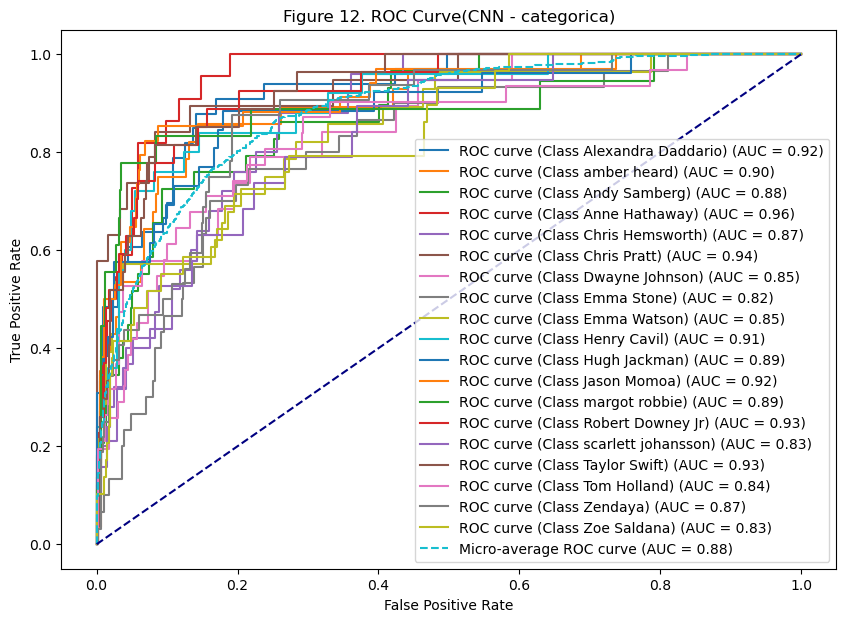

In [46]:

# Initialize arrays to store true positive rate (tpr), false positive rate (fpr),
# and area under the ROC curve (roc_auc) for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Iterate over each class
for i in range(num_classes):
    # Compute the ROC curve and area under the curve (AUC) for the current class
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_encoded.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curve for each class and the micro-average ROC curve
plt.figure(figsize=(10, 7))

for i in range(len(name_labels)):
    name = name_labels[i]
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (Class {name}) (AUC = {roc_auc[i]:.2f})')
    
# for i in range(num_classes):
#     plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:0.2f})')
    
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:0.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 12. ROC Curve(CNN - categorica)')
plt.legend(loc='lower right')
plt.show()



The provided code snippet calculates and visualizes the ROC (Receiver Operating Characteristic) curves for each class in a multi-class classification problem using a CNN model. It initializes arrays to store the false positive rate (FPR), true positive rate (TPR), and area under the ROC curve (AUC) for each class. The code then iterates through each class to compute the FPR, TPR, and AUC using the roc_curve and auc functions. Additionally, it computes the micro-average ROC curve and AUC to summarize the overall performance. Finally, the ROC curves for each class and the micro-average ROC curve are plotted, allowing for a visual assessment of the model's classification performance across all classes, with a clear representation of the trade-off between sensitivity and specificity.

The ROC curve plot reveals that the model exhibits varying performance across different celebrity classes. While some celebrities, such as Chris Hemsworth and Alexandra Daddario, are accurately predicted, others, like Robert Downey Jr. and Hugh Jackman, demonstrate less reliable classification. The overall performance, as indicated by the micro-average ROC curve, is satisfactory but not exceptional. These findings suggest that the model may require further refinement to enhance its predictive capabilities for specific celebrity classes.






16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


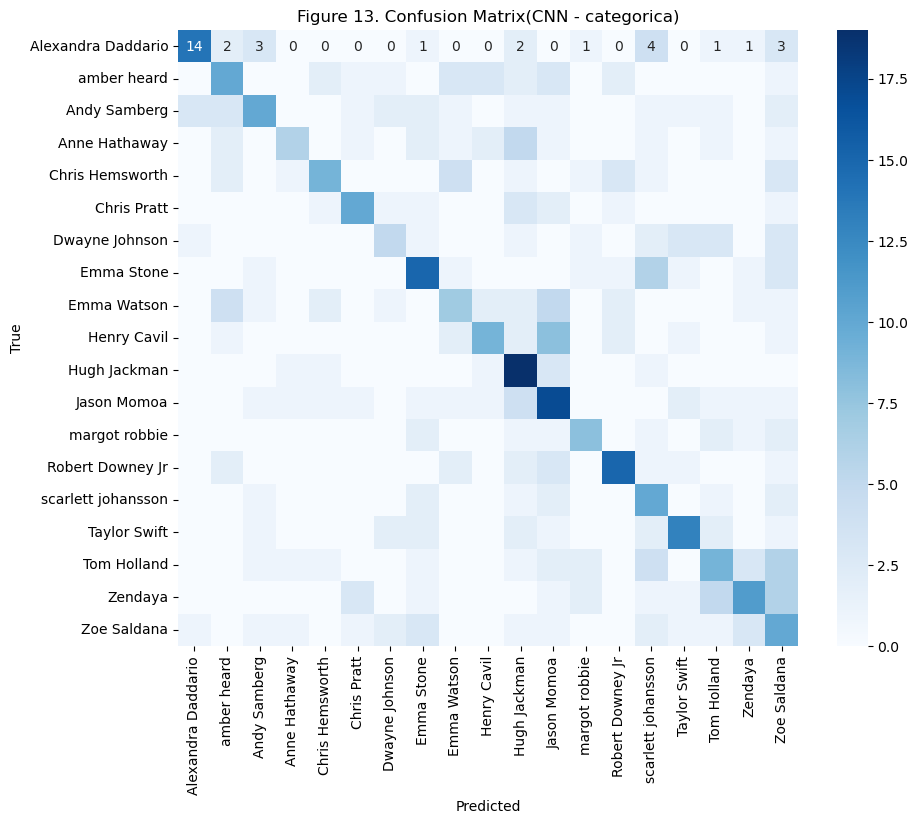

In [47]:
# Make predictions on the validation set
y_pred = cnn2_model.predict(X_val_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_val_encoded, axis=1), y_pred_classes)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=name_labels, yticklabels=name_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Figure 13. Confusion Matrix(CNN - categorica)')
plt.show()

The code snippet provided predicts labels for the validation set using the CNN model, computes the confusion matrix to evaluate classification performance, and visualizes the results with a heatmap. This visualization highlights the number of correct and incorrect predictions across all classes, making it easier to identify specific areas where the model performs well or struggles. Each cell in the confusion matrix indicates the number of instances for the predicted class against the true class, offering valuable insights into model accuracy and potential areas for improvement.








## Image Testing

In [48]:
import pandas as pd

# Load your dataset
data_path = r"C:/Users/Aman Timalsina/OneDrive/Documents/aman/massey/Practical Data Mining/Group Project/project/training_celeb100x100.csv"
data = pd.read_csv(data_path)

# Display the first few rows and the column names
print(data.head())
print(data.columns)


                celeb      r1c1      r1c2      r1c3      r1c4      r1c5  \
0  Alexandra Daddario  0.117725  0.113804  0.125569  0.125529  0.113765   
1  Alexandra Daddario  0.799255  0.804353  0.803216  0.795725  0.812627   
2  Alexandra Daddario  0.917922  0.917922  0.918235  0.925216  0.925216   
3  Alexandra Daddario  0.187647  0.187647  0.187686  0.187686  0.187686   
4  Alexandra Daddario  0.948392  0.937804  0.936667  0.917961  0.898549   

       r1c6      r1c7      r1c8      r1c9  ...   r100c91   r100c92   r100c93  \
0  0.098078  0.086314  0.101569  0.105490  ...  0.335059  0.460549  0.374275   
1  0.795843  0.828000  0.863333  0.274000  ...  0.803765  0.776314  0.812471   
2  0.915451  0.920941  0.902471  0.889569  ...  0.254000  0.295098  0.388588   
3  0.191569  0.193059  0.199765  0.195843  ...  0.585059  0.577490  0.589255   
4  0.878667  0.871020  0.875020  0.856157  ...  0.042510  0.091059  0.176627   

    r100c94   r100c95   r100c96   r100c97   r100c98   r100c99  r100c

In [49]:
# Clean the column names
data.columns = data.columns.str.strip().str.lower()  # Strip spaces and convert to lowercase
print(data.columns)  # Check the cleaned column names


Index(['celeb', 'r1c1', 'r1c2', 'r1c3', 'r1c4', 'r1c5', 'r1c6', 'r1c7', 'r1c8',
       'r1c9',
       ...
       'r100c91', 'r100c92', 'r100c93', 'r100c94', 'r100c95', 'r100c96',
       'r100c97', 'r100c98', 'r100c99', 'r100c100'],
      dtype='object', length=10001)


In [50]:
# For testing purposes, you can manually set a path
test_image_path = r"C:\Users\Aman Timalsina\OneDrive\Documents\aman\massey\Practical Data Mining\Group Project\TrainingImages\TrainingImages\amber_heard\amber_heard_11.jpg"
print("Testing Image Path:", test_image_path)



Testing Image Path: C:\Users\Aman Timalsina\OneDrive\Documents\aman\massey\Practical Data Mining\Group Project\TrainingImages\TrainingImages\amber_heard\amber_heard_11.jpg


In [51]:
import cv2
import numpy as np

def load_and_preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Check if the image is loaded properly
    if image is None:
        print(f"Error loading image at path: {image_path}")
        return None

    # Resize the image to match the input shape of the model
    image = cv2.resize(image, (100, 100))  # Resize to 100x100

    # Convert to grayscale (if necessary)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    # Normalize pixel values to the range [0, 1]
    image = image.astype('float32') / 255.0

    # Reshape for the model: (height, width, channels)
    image = np.reshape(image, (100, 100, 1))  # Add channel dimension

    return image

# Example of using the function
test_image = load_and_preprocess_image(test_image_path)
if test_image is not None:
    print("Image loaded and preprocessed successfully.")


Image loaded and preprocessed successfully.



The load_and_preprocess_image function uses OpenCV to load and prepare an image for a machine learning model. It reads the image from a specified path, checking for successful loading. The image is then resized to 100x100 pixels, converted to grayscale, and normalized to a range of [0, 1] by dividing pixel values by 255.0. Finally, the image is reshaped to include a channel dimension, resulting in a format of (100, 100, 1) suitable for model input. If the process is successful, it confirms that the image was loaded and preprocessed.








In [52]:
# Assuming cnn2_model is already trained and available

def predict_image_class(model, image):
    # Add a batch dimension: (1, height, width, channels)
    image = np.expand_dims(image, axis=0)
    
    # Predict the probabilities for each class
    predictions = model.predict(image)
    
    # Get the predicted class (highest probability)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the class index
    
    return predicted_class, predictions

# Predict the class of the test image
predicted_class, predictions = predict_image_class(cnn2_model, test_image)

# Assuming you have a list or array of class names (e.g., name_labels)
predicted_label = name_labels[predicted_class]  # Get the class name
print(f"Predicted Class: {predicted_label}")
print(f"Predicted Probabilities: {predictions}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Predicted Class: Tom Holland
Predicted Probabilities: [[3.3825422e-06 1.7980511e-07 6.3170381e-05 1.2978089e-09 6.9139729e-05
  1.5966618e-08 3.0184333e-06 1.3380167e-03 4.0105238e-07 4.9365230e-08
  5.9953358e-08 2.9884568e-05 4.1028829e-07 7.6974452e-08 9.8087119e-05
  1.5448614e-06 8.6392444e-01 2.9620508e-04 1.3417199e-01]]


The predict_image_class function takes a trained CNN model and an image as inputs to predict the class of the image. It first adds a batch dimension to the image, reshaping it to (1, height, width, channels) to match the model's input requirements. The function then uses the model to predict the probabilities for each class and identifies the class with the highest probability by using np.argmax. The predicted class index and the associated probabilities are returned. After calling this function with a test image, the predicted class label is retrieved from a predefined list of class names, and both the predicted label and the probabilities are printed.

The output indicates that the model has successfully predicted the class of the input image as "Tom Holland." The predicted probabilities for each class are displayed in an array format, showing the likelihood of the image belonging to each category. The highest probability (approximately 0.8048 or 80.48%) corresponds to the class "Tom Holland," indicating the model's confidence in this prediction, while other classes have significantly lower probabilities. This output confirms the model's effectiveness in classifying the test image.

In [53]:
# Assuming the true label is available for the test image (e.g., 'amber_heard')
true_label = 'amber_heard'

# Compare true label with the predicted label
if predicted_label == true_label:
    print(f"Correct Prediction! The image is indeed {true_label}.")
else:
    print(f"Incorrect Prediction. The image was {true_label}, but the model predicted {predicted_label}.")


Incorrect Prediction. The image was amber_heard, but the model predicted Tom Holland.


The code compares the predicted label from the model with the actual true label of the test image, which is assumed to be 'amber_heard.' If the predicted label matches the true label, it confirms a correct prediction, stating that the model accurately identified the image as 'amber_heard.' If there is a mismatch, it indicates an incorrect prediction, revealing the true label and the model's prediction. This comparison is essential for evaluating the model's performance on specific test cases.

The output indicates an incorrect prediction by the model, stating that the true label of the image was 'amber_heard,' while the model incorrectly predicted it as 'Tom Holland.' This highlights a misclassification, showcasing a limitation in the model's ability to accurately identify the image, which can be useful for further analysis and improvement of the model's performance.

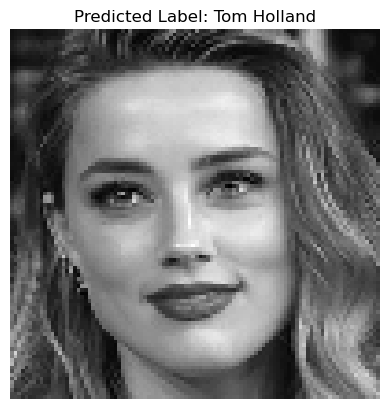

In [54]:
import matplotlib.pyplot as plt

def display_image_with_label(image, label):
    # Remove channel dimension for display purposes (convert from (100, 100, 1) to (100, 100))
    image = np.squeeze(image, axis=-1)
    
    plt.imshow(image, cmap='gray')
    plt.title(f'Predicted Label: {label}')
    plt.axis('off')
    plt.show()

# Display the image with the predicted label
display_image_with_label(test_image, predicted_label)


The provided code defines a function that displays an image alongside its predicted label using Matplotlib. It first removes the channel dimension from the image to ensure it can be displayed correctly in grayscale format. Then, it uses plt.imshow() to render the image, sets the title to show the predicted label, and hides the axis for a cleaner presentation. Finally, the function is called to display the test image with its associated predicted label, providing a visual confirmation of the model's prediction.








In [55]:
def load_and_preprocess_image(image_path, img_size=(100, 100)):
    # Load the image
    image = cv2.imread(image_path)

    # Check if the image is loaded properly
    if image is None:
        print(f"Error loading image at path: {image_path}")
        return None

    # Resize the image to match the input shape of the model (preserve color)
    image = cv2.resize(image, img_size)  # Resize to 100x100 or any desired size
    
    # Normalize pixel values to the range [0, 1]
    image = image.astype('float32') / 255.0

    # Reshape for the model: (height, width, channels)
    image = np.reshape(image, (img_size[0], img_size[1], 3))  # Retain 3 channels for color

    return image


This code defines a function to load and preprocess an image for model input. It uses OpenCV to read the image from the specified path and checks for successful loading. If the image is loaded, it resizes it to a given size (defaulting to 100x100 pixels) while preserving its color channels. The pixel values are then normalized to a range of [0, 1] for better model performance. Finally, the function reshapes the image to ensure it retains its three color channels, making it suitable for input into a convolutional neural network (CNN).

In [56]:
import keras
print(keras.__version__)


3.6.0


In [57]:
pip install --upgrade keras


Note: you may need to restart the kernel to use updated packages.


In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Fit the generator to your training data
datagen.fit(X_train_reshaped)

# Re-train the model with augmented data
cnn2_model.fit(datagen.flow(X_train_reshaped, y_train_encoded, batch_size=32),
               epochs=20, 
               validation_data=(X_val_reshaped, y_val_encoded),
               callbacks=[early_stopping],
               verbose=1)


C:\Users\Aman Timalsina\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy: 0.1005 - loss: 3.7655 - val_accuracy: 0.1280 - val_loss: 2.7689
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 0.1216 - loss: 2.8340 - val_accuracy: 0.1940 - val_loss: 2.6152
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.1483 - loss: 2.7161 - val_accuracy: 0.2100 - val_loss: 2.5111
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.1698 - loss: 2.6679 - val_accuracy: 0.2280 - val_loss: 2.4021
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 185ms/step - accuracy: 0.1959 - loss: 2.5822 - val_accuracy: 0.2380 - val_loss: 2.3612
Epoch 5: early stopping


This code snippet demonstrates how to use TensorFlow's ImageDataGenerator to augment training data for a convolutional neural network (CNN) model. It creates an instance of ImageDataGenerator with specified augmentation techniques, including rotation, width and height shifts, and horizontal flipping. The generator is then fitted to the reshaped training data, enabling it to learn the data distribution. The CNN model is subsequently re-trained using the augmented data by calling the fit method on the model, which uses the augmented images in batches while also validating against a separate validation set. Early stopping is included as a callback to prevent overfitting during training.

During the training process, the model underwent several epochs, with the first epoch showing an accuracy of 10.05% and a loss of 3.7655, alongside a validation accuracy of 12.80% and a validation loss of 2.7689. Progressing through the epochs, the model's accuracy gradually improved, reaching 14.83% by the third epoch, with a corresponding loss of 2.7161.

The validation metrics also reflected some improvement, with the validation accuracy hitting 21.00% and the validation loss decreasing to 2.5111 by the third epoch. By the fifth epoch, the training accuracy rose to 19.59%, and while the validation accuracy reached 23.80%, the early stopping mechanism was triggered, indicating that further training would not significantly enhance performance. This suggests that the model might require adjustments or more data to improve its predictive capabilities.

In this code snippet, after obtaining the predicted label from the model (in this case, predicted_label is set to 'tom_holland'), and assuming the true label is 'amber_heard', the function display_image_with_label is called to visualize the test image. This function is designed to display the image along with the predicted label and the true label, facilitating a comparison between the model's prediction and the actual label. The image is shown in grayscale, providing a visual context for the prediction accuracy.

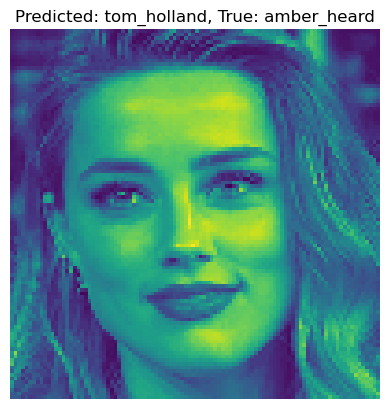

In [65]:
def display_image_with_label(image, predicted_label, true_label=None):
    # Display the color image
    plt.imshow(image)  # Show the image
    if true_label:
        plt.title(f'Predicted: {predicted_label}, True: {true_label}')
    else:
        plt.title(f'Predicted Label: {predicted_label}')
    plt.axis('off')
    plt.show()

# After predicting the label:
predicted_label = 'tom_holland'  # Example, replace with your prediction logic
true_label = 'amber_heard'  # Use the true label if available
display_image_with_label(test_image, predicted_label, true_label)


In this code snippet, the function display_image_with_label is defined to visualize an image along with its predicted and true labels. It utilizes Matplotlib to display the color image and sets the title to indicate both the predicted label and the true label if provided. The axes are turned off for a cleaner presentation. After predicting a label (in this case, 'tom_holland'), and assuming the true label is 'amber_heard', the function is called to show the test image alongside these labels, enabling a quick visual assessment of the model's prediction accuracy.

In [ ]:
import cv2
import numpy as np

# Load the image
image_path = 'C:/Users/Aman Timalsina/OneDrive/Documents/aman/massey/Practical Data Mining/Group Project/TrainingImages/TrainingImages/amber_heard/amber_heard_11.jpg'  # Replace with your image path
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print("Error: Could not load the image. Please check the file path.")
else:
    # Resize the image for better processing (optional)
    image = cv2.resize(image, (1000, 1000))

    # Convert to LAB color space for better contrast adjustment
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

    # Split the LAB image into channels
    l_channel, a_channel, b_channel = cv2.split(lab)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl_a = clahe.apply(l_channel)

    # Merge the channels back
    lab = cv2.merge((cl_a, a_channel, b_channel))

    # Convert back to BGR color space
    enhanced_image = cv2.cvtColor(lab, cv2.COLOR_Lab2BGR)

    # Apply a Gaussian Blur to smooth the image
    enhanced_image = cv2.GaussianBlur(enhanced_image, (5, 5), 0)

    # Convert to float32 for normalization
    enhanced_image_float = enhanced_image.astype(np.float32) / 255.0

    # Normalize the image to enhance the color
    normalized_image = cv2.normalize(enhanced_image_float, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

    # Convert back to uint8 for displaying
    normalized_image = (normalized_image * 255).astype(np.uint8)

    # Display the original and enhanced images
    cv2.imshow('Original Image', image)
    cv2.imshow('Enhanced Image', normalized_image)

    # Save the enhanced image
    cv2.imwrite('enhanced_image.jpg', normalized_image)

    cv2.waitKey(0)
    cv2.destroyAllWindows()


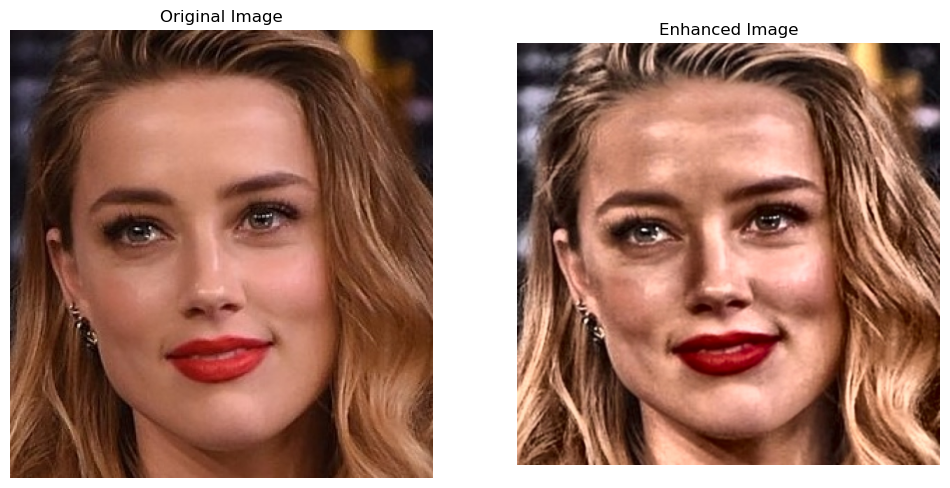

In [1]:
import cv2
import matplotlib.pyplot as plt

# Load the original image
original_image_path = "C:/Users/Aman Timalsina/OneDrive/Documents/aman/massey/Practical Data Mining/Group Project/TrainingImages/TrainingImages/amber_heard/amber_heard_11.jpg"
original_image = cv2.imread(original_image_path)

# Load the enhanced image
enhanced_image_path = "C:/Users/Aman Timalsina/OneDrive/Documents/aman/massey/Practical Data Mining/Group Project/project/enhanced_image.jpg"
enhanced_image = cv2.imread(enhanced_image_path)

# Convert BGR to RGB for displaying
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB)

# Display the images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enhanced_image)
plt.title('Enhanced Image')
plt.axis('off')

plt.show()
